# Homework - Categorization and Model Comparison Part B (40/110 points)

by *Todd Gureckis* and *Brenden Lake*  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/  

<div class="alert alert-danger" role="alert">
  This homework is due before midnight on April 25 2022. 
</div>

---

In [1]:
from IPython.display import display
import string as str
import os
import numpy as np
import seaborn as sns
import pandas as pd
import math
from random import random, randint, shuffle, uniform
from scipy.optimize import fmin, brute
from scipy.special import comb # gets the combinations function
from exemplarproto import *  # this grabs much of the code from Part A of the homework

## Fitting the models using maximum likelihood

As mentioned in the lecture, RMSE is not always an ideal mechanism for fitting models.  One reason is that it is insensitive to the number of observations that define each data point.  For example, remember in our experiment that participants saw the prototype item four times at test.  In contrast, there were 20 different "new" patterns.  This means there are five times as many trials contributing to the "new" bar in this graph as for the prototype patterns.  Since RMSE measures the raw deviation of the average model predictions from those of the model it doesn't take into account these issues.  Thus, we would like to also evaluate these two models using maximum likelihood.

The key to this is going to be the provided function below which computes the likelihood of a particular set of data under a binomial probability model.:

In [2]:
################################
# computeLogLikelihood
# N = number of observations
# S = number of "successes" (i.e., endorsements)
# p = predicted probability of successes by the model
################################
def computeLogLikelihood(N, S, p):
    p = p if p > 0.0 else 0.0+1e-10
    p = p if p < 1.0 else 1.0-1e-10
    try:
        result = math.log(comb(N, S)) + (S*math.log(p) + (N-S)*math.log(1.0-p))
    except:
        print(N, S, p)  # this shouldn't happen but just in case
        result = 0
    return result


def pandas_ll(row):
    return computeLogLikelihood(row['Total'], row['N_Yes'], row['Probability of Endorsement'])

A short explanation may be in order: the models predictions take the form of probabilities of endorsement for each of the prototype, low, high, random, and old items. If you find out that people endorse the prototype on 2 out of 2 trials how likely is this outcome given that the model (for a particular set of parameters ) predicts an endorsement of p=0.8? Three numbers are required to do this for each data point N, the number of trials/presentations within the stimulus class, S the number of successes observed (S<=N), and p the predicted probability. Then you can turn the crank on the above `computeLogLikelihood()` function which returns the probability that you would get $S$ successes in $N$ trials if the true probability was $p$ (make sure you understand what is happening in `computeLogLikelihood`). You can sum these log likelihoods for each stimulus class (prototype, low, high, random, old) to compute a total log(likelihood) of the data for any given model with any set of parameters.   For this homework will we focus on fitting the group data rather than to individuals.

To get the data formatted into an appropriate shape for fitting likelihoods we provide a function `get_human_results_ll()` which returns a Pandas data frame containing the number of times a pattern of a particular type was endorsed and the number of times it was presented for each subject.

In [3]:
human_res=get_human_results_ll()
human_res

,Subject,Condition,Stimulus Type,N_Yes,Total
0,./data/8.dat,cat,Prototype,4,4
1,./data/8.dat,cat,Low,4,4
2,./data/8.dat,cat,High,10,10
3,./data/8.dat,cat,Random,15,20
4,./data/8.dat,cat,Old,20,20
...,...,...,...,...,...
0,./data/7.dat,rec,Prototype,3,4
1,./data/7.dat,rec,Low,4,4
2,./data/7.dat,rec,High,8,10
3,./data/7.dat,rec,Random,0,20


This reorganizes the data per condition.

In [4]:
human_data=human_res.groupby(['Condition','Stimulus Type']).sum()
human_data

N_Yes  Total
Condition Stimulus Type              
cat       High              49     70
          Low               26     28
          Old              110    140
          Prototype         25     28
          Random            37    140
rec       High              20     70
          Low               16     28
          Old               89    140
          Prototype         18     28
          Random             7    140

Finally these function allow us to compute the negative log likelihood of the data given the model.

In [5]:
def fit_exemplar_model_nll(params, human_results):
    [c_cat, k_cat, c_rec, k_rec] = params
    k_cat = k_cat if k_cat > 0.0 else 0.0
    k_rec = k_rec if k_rec > 0.0 else 0.0
    predictions = get_exemplar_results(c_cat, k_cat, c_rec, k_rec)
    model = predictions.groupby(
        ['Condition', 'Stimulus Type'], as_index=False).mean()
    fitted_data = pd.merge(model, human_results)
    return -1.0*fitted_data.apply(pandas_ll, axis=1).sum()


def fit_prototype_model_nll(params, human_results):
    [c_cat, k_cat, c_rec, k_rec] = params
    k_cat = k_cat if k_cat > 0.0 else 0.0
    k_rec = k_rec if k_rec > 0.0 else 0.0
    predictions = get_prototype_results(c_cat, k_cat, c_rec, k_rec)
    model = predictions.groupby(
        ['Condition', 'Stimulus Type'], as_index=False).mean()
    fitted_data = pd.merge(model, human_results)
    return -1.0*fitted_data.apply(pandas_ll, axis=1).sum()

<div class="alert alert-success" role="alert">
<h3> Problem 6 (20 points) </h3><br>
The cell blocks below allow you to fit the exemplare model and the prototype model to the dataset we considered in Part A of the homework. Make sure you understand and follow the code provided above and in the provided library (exemplarproto.py).  Next, try altering the parameters to minimize the negative log likelihood score.  When you think you have found the best fit parameters for both the exemplar and prototype models report your final parameter values along with the plot of the resulting model predictions.  In a markdown cell describe which model you believe fits better.  Is this conclusion the same or different from what you considered in Part 4 of the homework?  If the fit looks different, why?
</div>

Answer:  
best_examplar_param [1.48769296 0.35961247 1.93041277 0.78398669] -> NL score 28.268922073692416  
best_prototype_param [1.58816955 0.03164535 1.87904483 0.08402034] -> NL score 32.246756097276645  
  
I believe exemplar model fits better than prototype model because its negative log (NL) score is lower than that of prototype model as shown above. Looking at the endorsement probability graph, exemplar model does much better in old and high stimulus, but it is worse in prototype and low stimulus types. The general trend was that exemplars tend to underestimate and prototypes tend to overestimate compared to human model. This conclusion is same as what I considered in Part 4 because exmplar did better with well performing old and high stimuli. The fit looks similar as well with both exemplar and prototype models.

In [8]:
human = human_res.groupby(['Condition', 'Stimulus Type'], as_index=False).sum()
initial_x0 = [1.73818548, 0.17362409, 1.92580663, 0.66919728]

best_examplar_param = fmin(fit_exemplar_model_nll, x0=initial_x0, args=(human,), full_output=True)
best_prototype_param = fmin(fit_prototype_model_nll, x0=initial_x0, args=(human,), full_output=True)

print('best_examplar_param',best_examplar_param[0])
print('best_prototype_param',best_prototype_param[0])

Optimization terminated successfully.
         Current function value: 28.268922
         Iterations: 105
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: 32.246756
         Iterations: 245
         Function evaluations: 405
best_examplar_param [1.48769296 0.35961247 1.93041277 0.78398669]
best_prototype_param [1.58816955 0.03164535 1.87904483 0.08402034]


**Exemplar model**

The negative log score is 28.268922073692416


<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

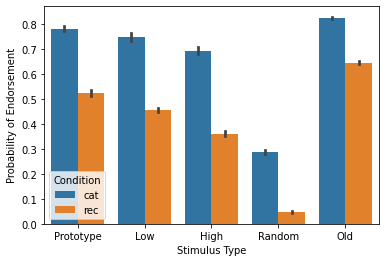

In [9]:
params = [1.48769296, 0.35961247, 1.93041277, 0.78398669]
nllfit = fit_exemplar_model_nll(params, human)
print(f'The negative log score is {nllfit}')

# now plot the data
c_cat, k_cat, c_rec, k_rec = params
res = get_exemplar_results(c_cat, k_cat, c_rec, k_rec)
sns.barplot(x="Stimulus Type", y="Probability of Endorsement",
            hue="Condition", data=res)

**Prototype Model**

The negative log score is 32.246756097276645


<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

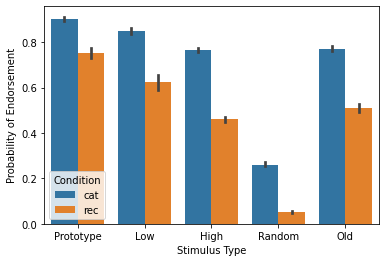

In [10]:
# human = human_res.groupby(['Condition', 'Stimulus Type'], as_index=False).sum()

params = [1.58816955, 0.03164535, 1.87904483, 0.08402034]
nllfit = fit_prototype_model_nll(params, human)
print(f'The negative log score is {nllfit}')

# now plot the data
c_cat, k_cat, c_rec, k_rec = params
res = get_prototype_results(c_cat, k_cat, c_rec, k_rec)
sns.barplot(x="Stimulus Type", y="Probability of Endorsement",
            hue="Condition", data=res)

**Human data again for reference**

<AxesSubplot:xlabel='Stimulus Type', ylabel='Probability of Endorsement'>

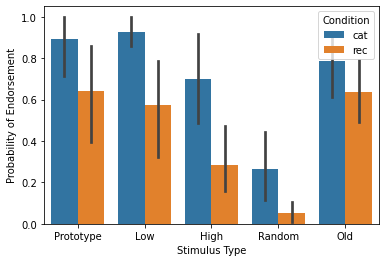

In [11]:
sns.barplot(x="Stimulus Type", y="Probability of Endorsement",
            hue="Condition", data=get_human_results())

<div class="alert alert-success" role="alert">
<h3> Problem 7 (10 points) </h3><br>
A famous saying is the "All models are wrong, but some are useful" (George Box).  Do you think the exemplar or prototype model provides the best account of the data?  Refer to particular patterns in the data that you believe the different models do a better job with.
</div>

With both RMSE and NLL scoring methods, examplar model performed better than prototype model. However, I believe this is difficult to say one method is much better than the other because each method has different upsides. Examplar model takes into account multiple patterns and finds the similarity which make it better for finding more distorted patterns and specific patterns from the original training data. This is shown in the graphs where examplar performs well with high distortion, random, and old stimuli. On the other hand, prototype model creates a representative prototype and finds similarity with the train data. This make this method stronger at finding averaged/less distorted data, proven by the graphs that show good performance on prototype, low, and random stimuli. As a result, in the five stimulus types, examplar model did slightly better on average, but not by a huge margin.

<div class="alert alert-success" role="alert">
<h3> Problem 8 (5 points) </h3><br>

Thinking about how these models work explain why both the exemplar and prototype models have relatively high endorsement for the prototype item even though it was never presented during the training phase.  In addition, explain in your own words why the models are able to explain the high endorsement rates for the old items.
    
</div>

Both exemplar and prototype models have relatively high endorsement for the prototype stimulus because both methods are able to find similarity in the given pattern through mulitple examples (in the case of exemplar) and through creating a single representative prototype (in the case of prototype). Since both methods are essentially doing the same comparision, it makes sense they perform well for endorsing prototype item. In addition, these models are also able to explain the old items with high endorsement rate because examplar keeps the memory of train data, and prototype can compute high similarity with old items to its representative data. Nonetheless, examplar has higher endorsement rate because it can recognize the exact patterns it has seen previously.

<div class="alert alert-success" role="alert">
<h3> Problem 9 (5 points) </h3><br>

Are the exemplar model and the prototype model we considered nested?  Would we compare them using AIC, BIC, or the G^2 statistic (or something else)?

</div>

Exemplar and prototype models are not nested. By definition, a nested model is simply a regression model that contains a subset of the predictor variables in another regression model. Exemplar model stores all training examples/data and use them for similarity calculation, but prototype model stores the represenation of the training data. This means one model cannot be a subset of another model for both exemplar and prototype models. When we compare the two models, AIC and BIC may be valid since both methods combine a term reflecting how well the model fits the data with a term that penalizes the model in proportion to its number of parameters. However, G^2 statistic is widely used for comparing the fit of nested models, which may not be a good fit for comparing exemplar and prototype models.